<center><h1>APS Failure Data Project</h1></center>

# APS Failure Prediction Using Tree-Based Models

This project explores machine learning approaches for detecting rare mechanical failures in the **APS (Air Pressure System) Failure dataset** from Scania Trucks.  
The dataset contains **170 real-valued sensor readings** and is extremely **imbalanced**, with only ~1.6% of samples belonging to the positive (failure) class.

Because APS failures can result in costly breakdowns and safety hazards, accurately identifying failures is essential — yet difficult due to data imbalance, missing values, and noisy sensor readings.

This notebook walks through the full ML pipeline:
- Data cleaning and imputation  
- Feature exploration and variability analysis  
- Baseline Random Forest modeling  
- Balanced modeling using class weighting  
- Advanced modeling with XGBoost + L1 regularization  
- Oversampling with SMOTE  
- Final performance comparison across methods  

## 1. Introduction

The APS Failure dataset represents a realistic industrial scenario involving:
- **High-dimensional numeric data**  
- **Long-tailed class distribution**  
- **Missing sensor readings**  
- **Complex interactions among features**

The goal of this project is to build interpretable and effective models to identify the rare failure events while mitigating the challenges posed by the dataset.

We evaluate several tree-based models and imbalance-handling strategies, focusing on performance measured via **ROC curves**, **AUC**, **confusion matrices**, and **recall**, which is critical for detecting positive failure cases.


## 2. Dataset Overview

The dataset consists of:
- **Training set:** ~60,000 samples  
- **Test set:** similar feature dimensions  
- **170 numeric features**  
- **Binary target:**  
  - `neg` = no failure  
  - `pos` = failure  

The positive class is extremely rare, making most naive models biased toward predicting the majority ("no failure") class.

This section loads the dataset and displays basic structural information.


## 3. Data Loading

We load the training and test CSV files, verify their dimensions, inspect the first few rows, and check class distribution.

Key things we look for here:
- Are all columns numeric?  
- Are there unexpected text values?  
- Are target labels encoded correctly?  
- Are there any missing columns?  

This section sets the foundation for preprocessing.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [31]:
#first 20 rows are extra information, so we skip them when loading data into dataframe 
train_data = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=20,na_values='na')
test_data = pd.read_csv('../data/aps_failure_test_set.csv', skiprows = 20, na_values='na')

#ASSIGNING O OR 1 from "class" column 
train_data.loc[train_data["class"] == "neg", "class"] = 0
train_data.loc[train_data["class"] == "pos", "class"] = 1

test_data.loc[test_data["class"] == "neg", "class"] = 0
test_data.loc[test_data["class"] == "pos", "class"] = 1

#X features vs y class separation 
X_train = train_data.drop('class', axis=1)
y_train = train_data['class']

X_test = test_data.drop('class', axis=1)
y_test =test_data['class']


## 4. Handling Missing Data

The dataset contains **substantial missingness** across many features, making simple row deletion impossible.

We consider common imputation techniques:
- **Median imputation:** robust to outliers  
- **Mean imputation:** simple but sensitive to skew  
- **KNN imputation:** uses nearest neighbors  
- **Iterative imputation:** predicts missing values using regression models  

For scalability and consistency, we select a computationally efficient imputation method and apply it across all features.

We then validate:
- Reduction in missing values  
- Data type consistency  
- No leakage between train/test  


####  Research what types of techniques are usually used

Some techniques that are used to handle missing data are either dropping the NaN values (although this was not a good idea for this dataset because it has a lot of missing data), or data imputation techniques. This essentially means dealing with missing data values by filling them in based on the data that is present. Some common data imputation techniques are filling in the missing values with the data mean/median/mode. Another is to use model-based imputation, such as using KNN or regression techniques to fill the missing data. For the following steps, we will apply the median data imputation, as using KNN or a regression imputer will take very long. 

Source: https://www.datacamp.com/tutorial/techniques-to-handle-missing-data-values

## 5. Exploratory Feature Analysis

To understand data variability and reduce redundancy, we examine several properties.

#### Median Imputation

In [3]:
#MEDIAN IMPUTATION IS BEING APPLIED 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

imputer.fit(X_train)

X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test_imputed  = pd.DataFrame(imputer.transform(X_test),  columns=X_test.columns)

### 5.1 Coefficient of Variation (CV)
CV = standard deviation / mean.

Features with higher CV tend to carry more signal.  
We compute CV for all 170 features and identify the most variable ones.


In [5]:
#CV  = s/m 

#COMBINING TRAIN AND TEST BASED ON TA: Mingyu Zong who mentioned to compute the following bii-biv on the entire set (train+test combined into one) 
X_all = pd.concat([X_train_imputed, X_test_imputed], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)

#CV FOR ALL
stdevall = X_all.std(ddof = 1) 
meanall = X_all.mean() 

CVall = stdevall/meanall
CVdfall = pd.DataFrame({"CV":CVall})
CVdfall



,CV
aa_000,4.328608
ab_000,9.740521
ac_000,2.309299
ad_000,274.791581
ae_000,23.271357
...,...
ee_007,4.935407
ee_008,3.373896
ee_009,5.821008
ef_000,50.223681


### 5.2 Correlation Matrix
We visualize inter-feature correlations to:
- Detect groups of highly correlated sensors  
- Identify redundancy  
- Understand underlying structure in the APS system  


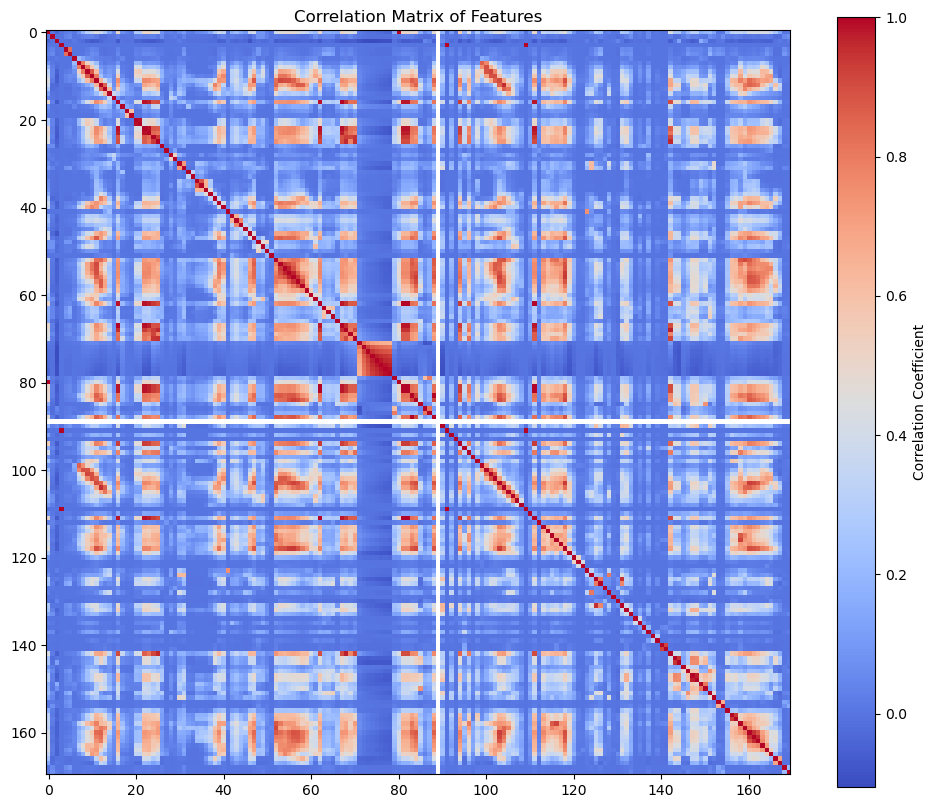

In [6]:
correlationmat = X_all.corr()

#using seaborn heatmap
plt.figure(figsize=(12, 10))
plt.imshow(correlationmat,cmap = "coolwarm")
plt.colorbar(label='Correlation Coefficient')
plt.title("Correlation Matrix of Features")
plt.show()


### 5.3 High-Variance Feature Visualization
Using the top CV features, we generate:
- **Scatter plots**  
- **Box plots**

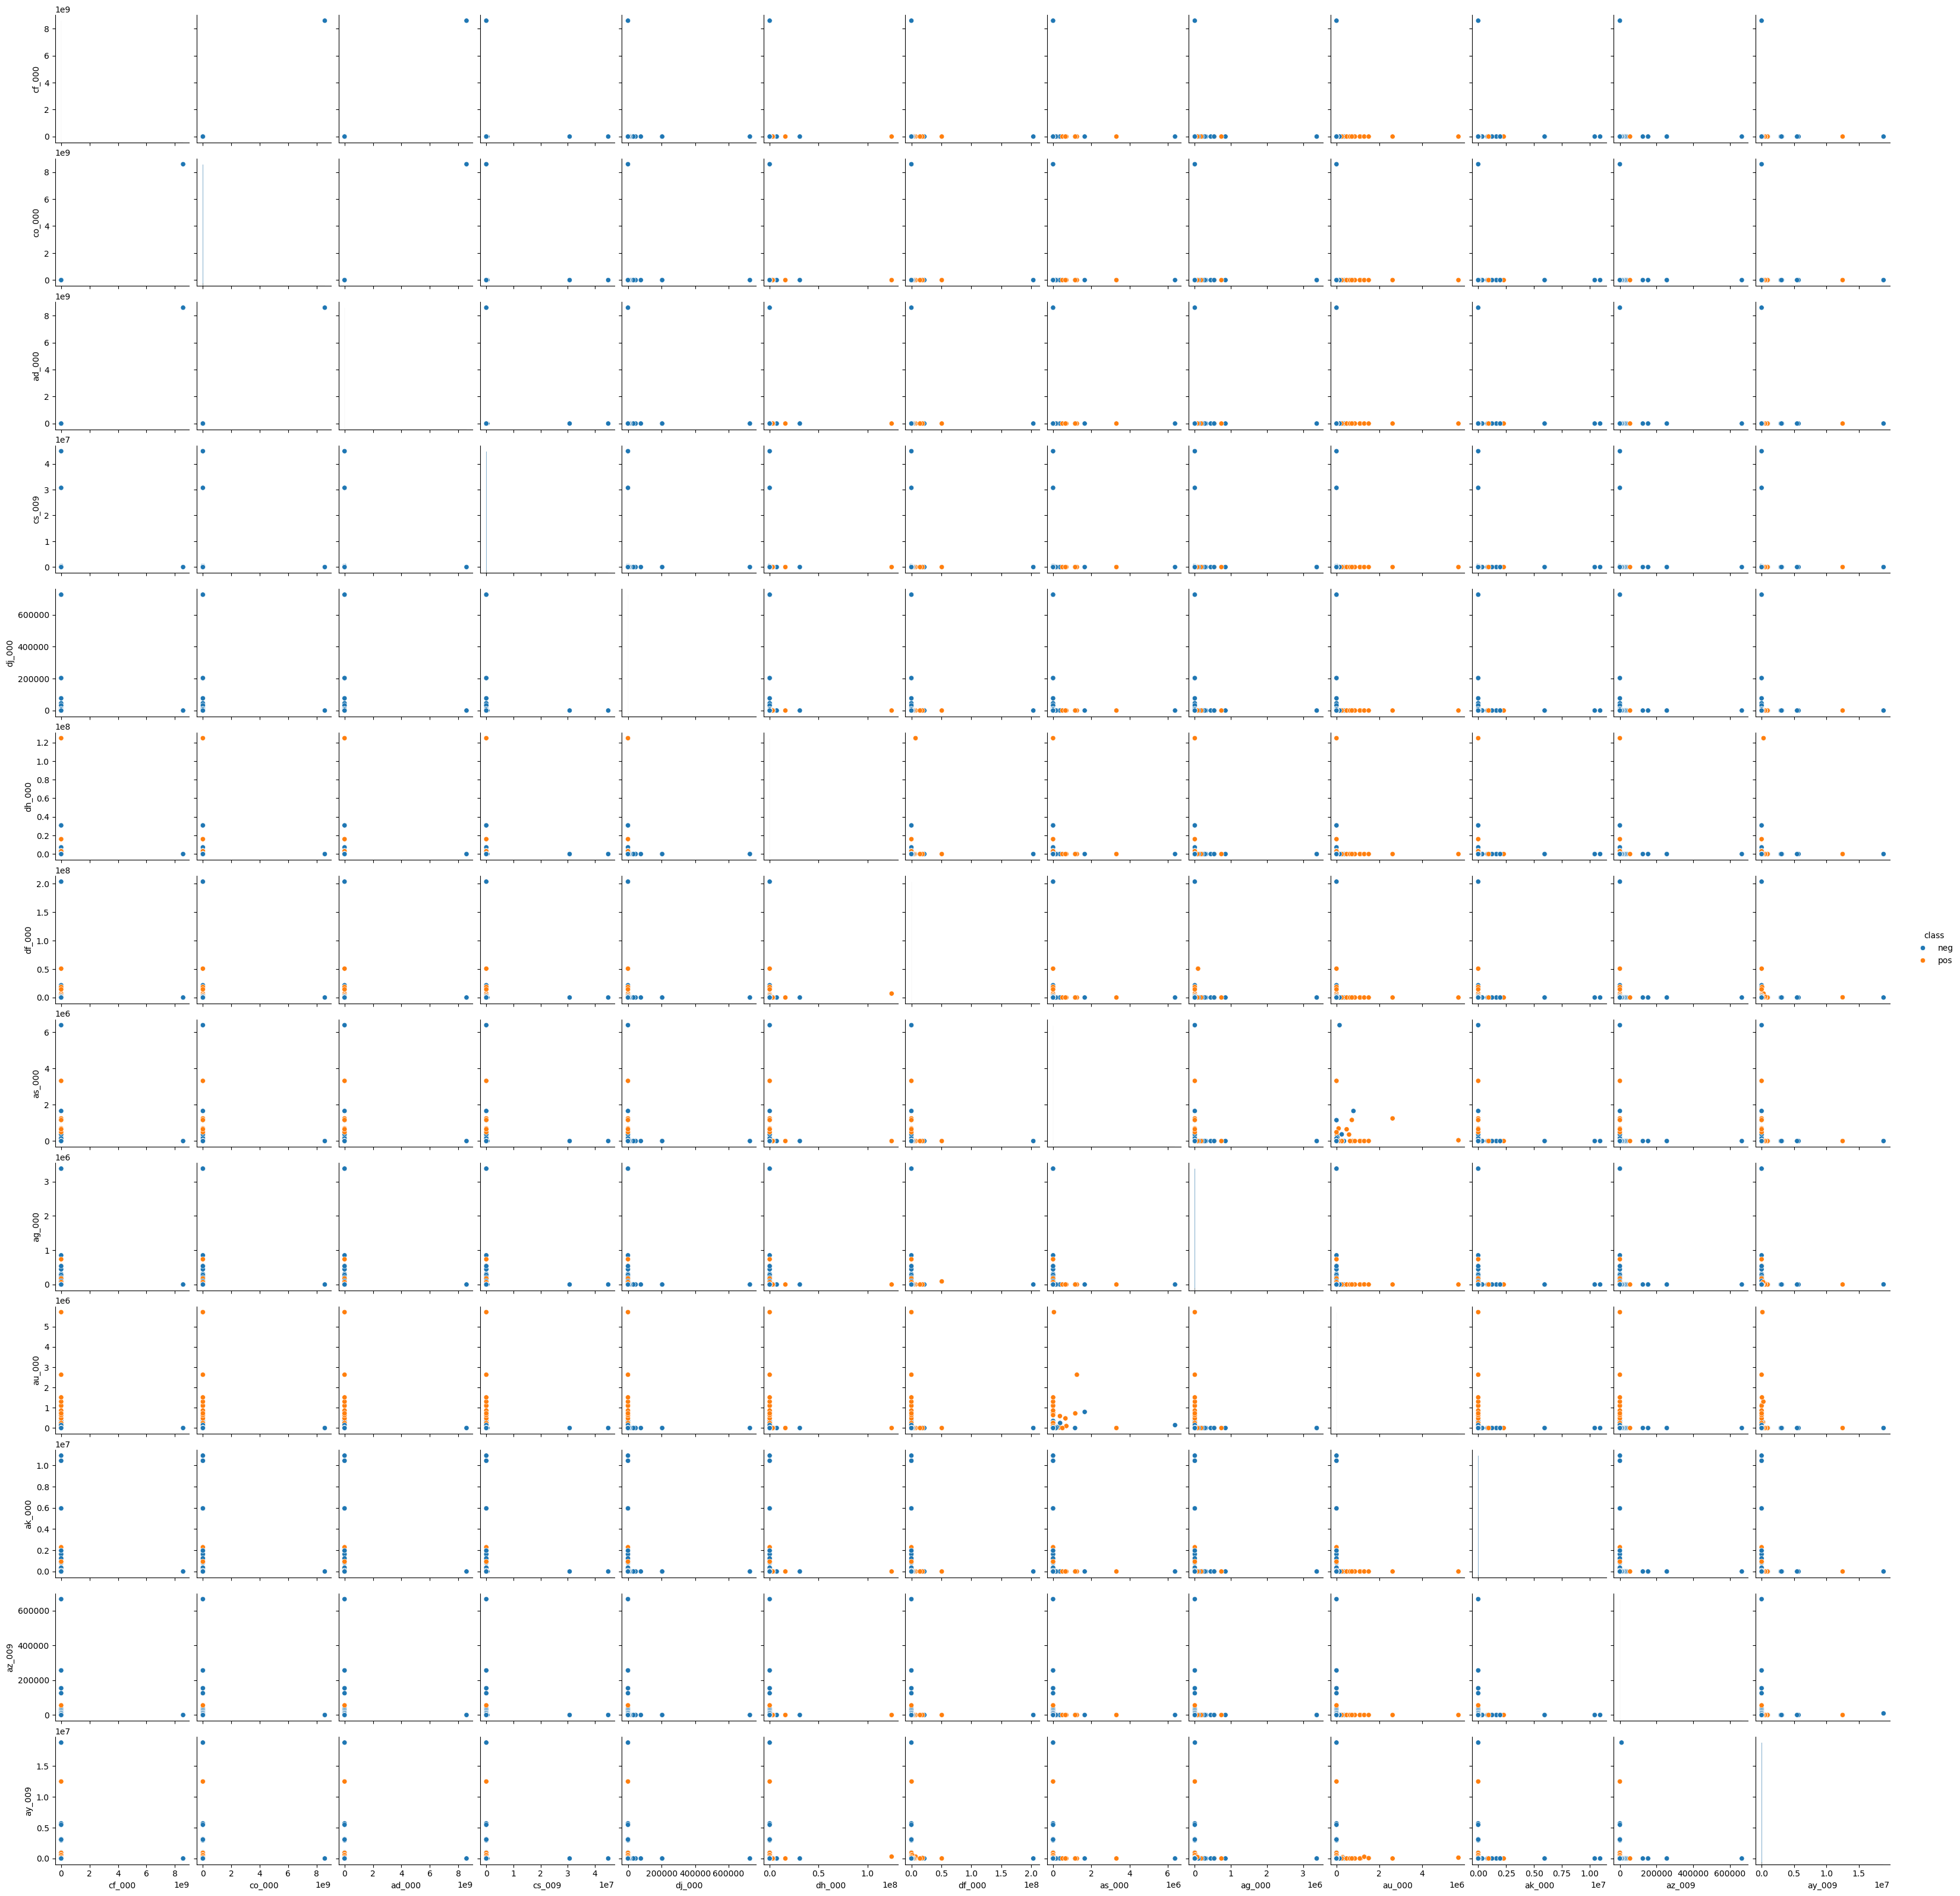

In [7]:
#sqrt170 = 13 so pick 13 highest features 

highestCV = CVdfall.sort_values(by="CV", ascending=False).iloc[:13]
features = highestCV.index.tolist()

#df of only 13 top features of entire dataset 

X_alltop = X_all[features].copy()

X_alltop["class"] = y_all.map({0: "neg", 1: "pos"}) #making colored difference similar to ISLR textbook

sns.pairplot(X_alltop, vars=features, hue="class", diag_kind="hist")
plt.show() 



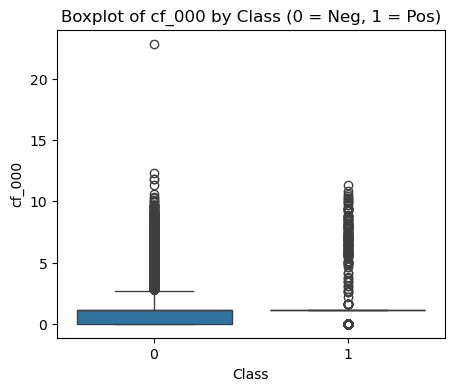

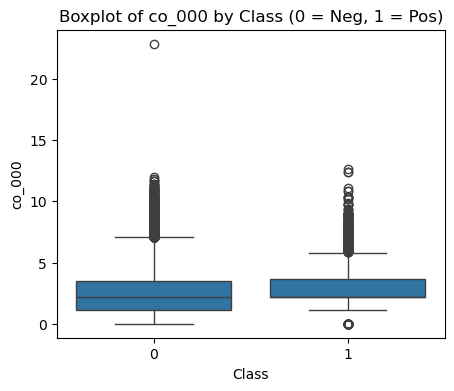

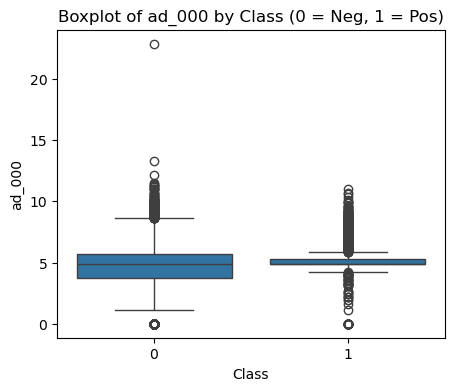

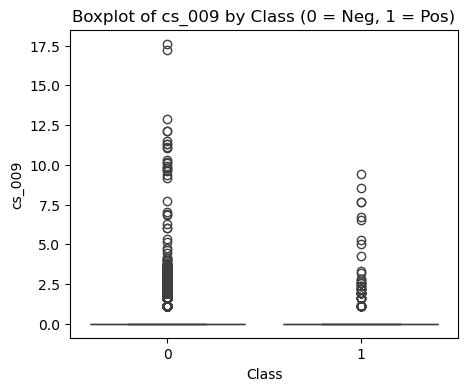

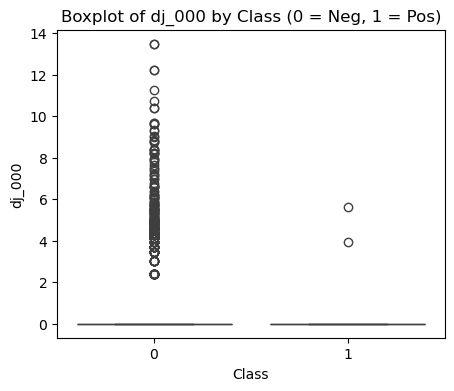

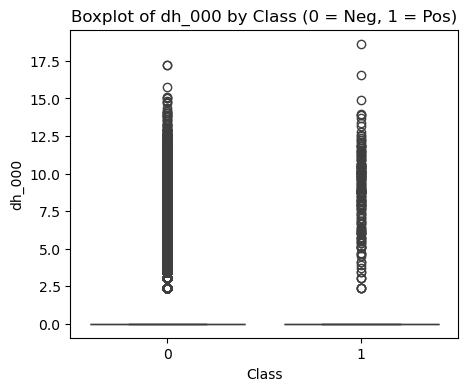

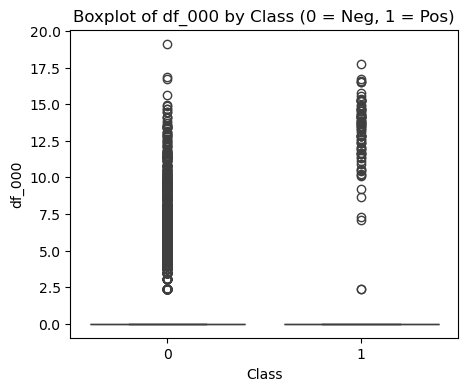

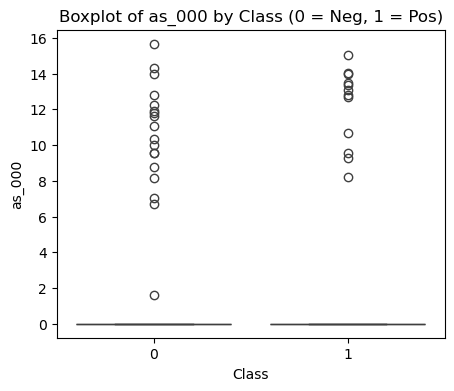

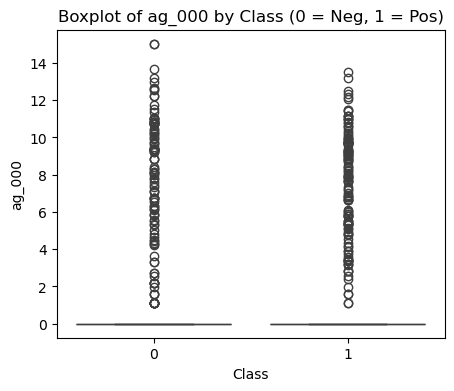

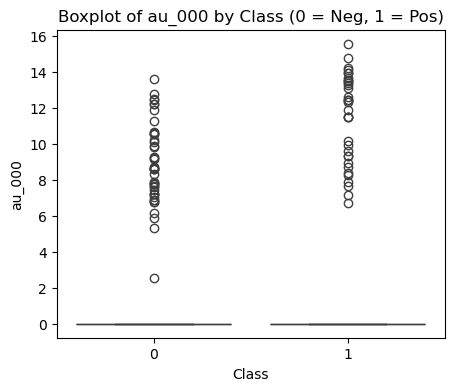

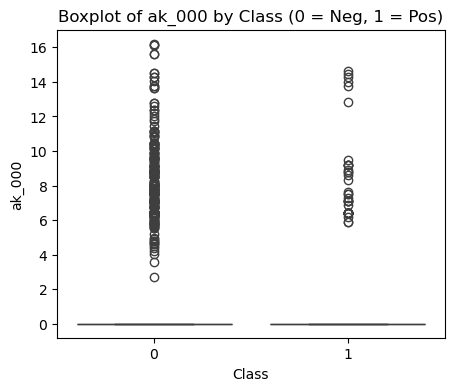

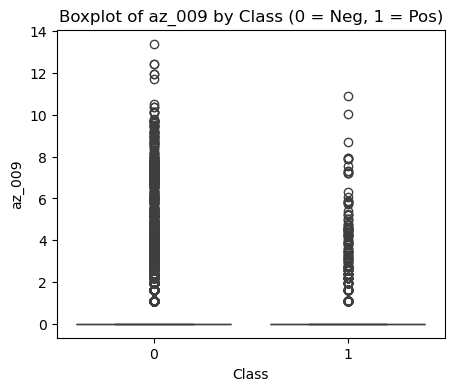

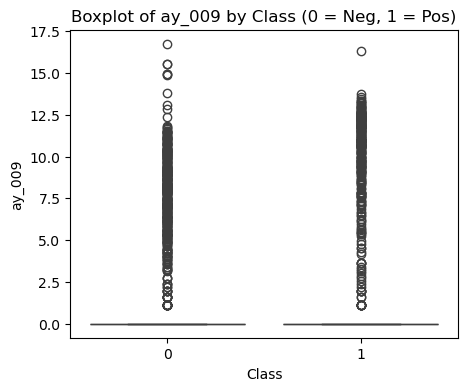

In [8]:
#boxplot 

databox = X_alltop[features]
logdatabox = np.log1p(databox) #scale issues when initially running the boxplot code, so I performed log 

X_alltop["class"] = y_all
logdatabox["class"] = X_alltop["class"] 

for feat in features:
    plt.figure(figsize=(5, 4))
    sns.boxplot(
        x="class",      
        y=feat,         
        data=logdatabox
    )
    plt.title(f"Boxplot of {feat} by Class (0 = Neg, 1 = Pos)")
    plt.xlabel("Class")
    plt.ylabel(feat)
    plt.show()

These plots help reveal:
- Skewness  
- Outliers  
- Group separability (if any) between `pos` and `neg` classes  

Although visual patterns may not directly determine importance, they provide intuition for downstream modeling.

---

## 6. Class Imbalance Assessment

APS failures are **extremely rare**, making this a challenging binary classification task.

We quantify:
- Number of `pos` (failures)  
- Number of `neg` (non-failures)  
- Imbalance ratio  

Why imbalance matters:
- Accuracy becomes misleading  
- Models tend to predict only the majority class  
- Recall for the minority class drops dramatically  
- Metrics like ROC-AUC, PR-AUC, and F1-score become more relevant  

This motivates the later use of **class-weighting** and **SMOTE**.


In [10]:
classcountall = y_all.value_counts()
print(classcountall)

classcounttrain = y_train.value_counts()
print(classcounttrain)

classcounttest = y_test.value_counts()
print(classcounttest)

class
0    74625
1     1375
Name: count, dtype: int64
class
0    59000
1     1000
Name: count, dtype: int64
class
0    15625
1      375
Name: count, dtype: int64


According to the class counts above, yes, the data set is imbalanced with much more negative class representation than the positive representation. 74625/(74625+1375) = 98.20% negative representation and only 1.8% positive representation. So the entire dataset is indeed imbalanced. It is also imbalanced for train and test too, shown above in the last two calculations, respectively. 

## 7. Baseline Model: Random Forest (Unbalanced)

### 7.1 Model Training
We begin with a standard Random Forest classifier using default settings.  
This provides an unbiased baseline before applying any imbalance-handling techniques.

### 7.2 Model Evaluation
We evaluate:
- Confusion matrix (train & test)  
- ROC curves  
- AUC scores  
- Misclassification rates  

This baseline is expected to have:
- High accuracy  
- Very poor recall for failure (`pos`) cases  
- Strong bias toward majority class  



In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, accuracy_score, roc_curve 

#changing from object to int so RandomForestClassifier can be applied (was throwing errors)

y_train = y_train.astype(int)
y_test  = y_test.astype(int)

#random forest 

randomf = RandomForestClassifier(n_estimators = 200, max_features = "sqrt", oob_score = True, random_state = 33, n_jobs = -1)
randomf.fit(X_train_imputed, y_train) 

#predictions

y_train_pred = randomf.predict(X_train_imputed)
y_test_pred = randomf.predict(X_test_imputed)

#confusion matrix of test AND train
conftrain = confusion_matrix(y_train, y_train_pred)
conftest = confusion_matrix(y_test, y_test_pred)

In [ ]:
#probabilities 
y_train_proba = randomf.predict_proba(X_train_imputed)[:, 1]
y_test_proba = randomf.predict_proba(X_test_imputed)[:, 1]

trainauc = roc_auc_score(y_train, y_train_proba)
testauc = roc_auc_score(y_test, y_test_proba)

#misclassification (going to calculate train and test error) 
train_error = 1 - accuracy_score(y_train, y_train_pred)
test_error = 1 - accuracy_score(y_test, y_test_pred)

### 7.3 Out-of-Bag Error
Random Forests offer an OOB error estimate that approximates test error without explicit cross-validation.  
We compare OOB error with real test performance to confirm model stability.


The training confusion matrix is [[59000     0]
 [    0  1000]]
The test confusion matrix is [[15608    17]
 [  107   268]]
The train AUC is 1.0
The test AUC is 0.994289152
The train error is 0.0
The test error is 0.007750000000000035
OoB error: 0.005766666666666698
Compared to the test error of 0.007750000000000035 ,the Out-of-Bag Error from the Random Forest is lower, at 0.005766666666666698


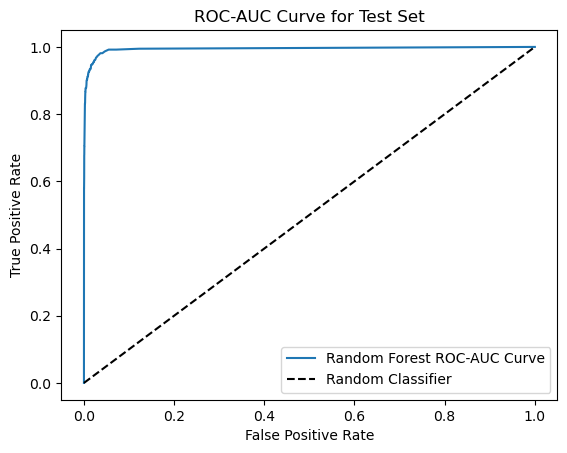

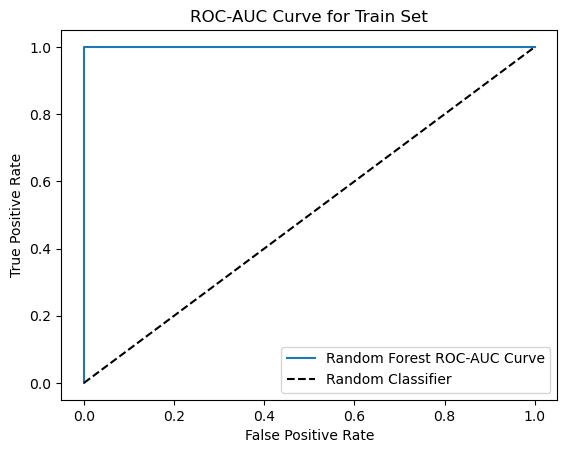

In [ ]:
#OOB error for random forest 

oob_error = 1-randomf.oob_score_ 

#plotting roc_curve for test 
plt.figure()
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label = "Random Forest ROC-AUC Curve")
plt.plot([0,1],[0,1],'k--',label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Test Set")
plt.legend()

#plotting roc_curve for train 
plt.figure()
fpr, tpr, _ = roc_curve(y_train, y_train_proba)
plt.plot(fpr, tpr, label = "Random Forest ROC-AUC Curve")
plt.plot([0,1],[0,1],'k--',label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Train Set")
plt.legend()


print("The training confusion matrix is", conftrain)
print("The test confusion matrix is", conftest) 
print("The train AUC is", trainauc)
print("The test AUC is" , testauc) 
print("The train error is", train_error) 
print("The test error is" , test_error) 
print("OoB error:", oob_error)
print("Compared to the test error of" , test_error, ",the Out-of-Bag Error from the Random Forest is lower, at",oob_error)

Another way to find misclassification is simply by looking at the confusion matrices. For the training confusion matrix, there are no false positives or negatives, but for the testing confusion matrix, there is 16 FN and 101 FP. 

## 8. Balanced Random Forest (Class-Weighted)
### 8.1 Rationale
Class weights adjust the model’s penalty for misclassifying the minority class, making it more sensitive to failure cases.


Some ways of handling class imbalance in random forest is Bootstrap Aggregation, Undersampling the majority class or Oversampling the minority class works too. Additionally, using class weighting is also another option. Class weighting will be used here. 

Source: https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

### 8.2 Training
We apply class weighting directly inside the Random Forest classifier.

In [13]:
randomfbalanced = RandomForestClassifier(n_estimators = 200, max_features = "sqrt", oob_score = True, class_weight = "balanced", random_state = 33, n_jobs = -1)
randomfbalanced.fit(X_train_imputed, y_train) 

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [14]:
randomfbalanced.fit(X_train_imputed, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


### 8.3 Evaluation
We measure the improvement in:
- Minority-class recall  
- AUC  
- Overall detection ability  

This model typically outperforms the unbalanced version on failure detection.


The training confusion matrix is [[59000     0]
 [    0  1000]]
The test confusion matrix is [[15609    16]
 [  156   219]]
The train AUC is 1.0
The test AUC is 0.9931358720000001
The train error is 0.0
The test error is 0.010750000000000037
OoB error: 0.007383333333333297


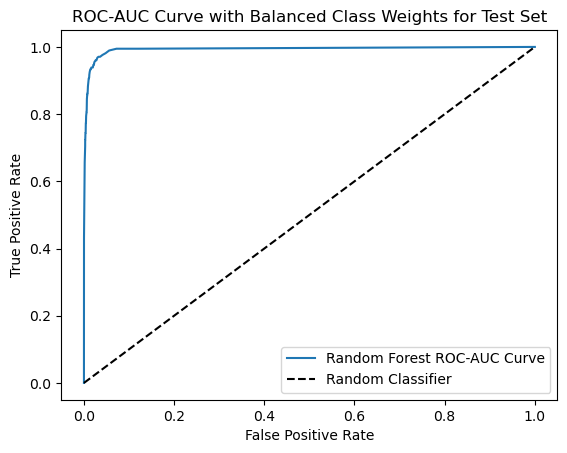

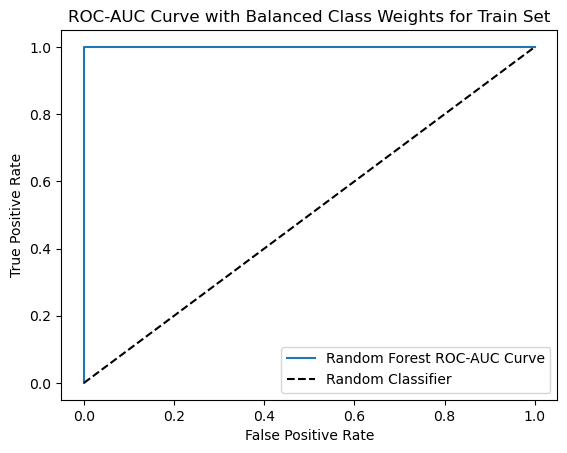

In [25]:
y_pred_train_balanced = randomfbalanced.predict(X_train_imputed)
y_pred_test_balanced = randomfbalanced.predict(X_test_imputed)

#conf matrix 
conftrainbal = confusion_matrix(y_train, y_pred_train_balanced)
conftestbal = confusion_matrix(y_test, y_pred_test_balanced)

#test and train error
trainerrorbal = 1-accuracy_score(y_train, y_pred_train_balanced)
testerrorbal = 1-accuracy_score(y_test, y_pred_test_balanced)

#auc 
y_train_proba_bal = randomfbalanced.predict_proba(X_train_imputed)[:, 1]
y_test_proba_bal = randomfbalanced.predict_proba(X_test_imputed)[:, 1]

trainaucbal = roc_auc_score(y_train, y_train_proba_bal)
testaucbal = roc_auc_score(y_test, y_test_proba_bal)

oob_err_balanced = 1 - randomfbalanced.oob_score_

#plotting ROC curve for test
plt.figure()
fpr, tpr, _ = roc_curve(y_test, y_test_proba_bal)
plt.plot(fpr, tpr, label = "Random Forest ROC-AUC Curve")
plt.plot([0,1],[0,1],'k--',label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve with Balanced Class Weights for Test Set")
plt.legend()

#plotting ROC curve for train
plt.figure()
fpr, tpr, _ = roc_curve(y_train, y_train_proba_bal)
plt.plot(fpr, tpr, label = "Random Forest ROC-AUC Curve")
plt.plot([0,1],[0,1],'k--',label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve with Balanced Class Weights for Train Set")
plt.legend()


print("The training confusion matrix is", conftrainbal)
print("The test confusion matrix is", conftestbal) 
print("The train AUC is", trainaucbal)
print("The test AUC is" , testaucbal) 
print("The train error is", trainerrorbal) 
print("The test error is" , testerrorbal) 
print("OoB error:", oob_err_balanced)

Compared to the unbalanced classifier in 1c, the misclassifications for the test conf matrix is almost worse for the FN and FP, as there are 15 FN which is better than FN for the unbalanced classifier (with 16 FN) but there are more FP in the balanced classifier (159 vs 101 for unbalanced). The test AUC is slightly lower for balanced classifier. The test error for the balanced dataset is higher, as well as the OoB error between 1d and 1c (higher for 1d). So balancing the data actually does a worse job for Random Forest which is interesting. See the table below for a clearer comparison.

In [26]:
comparingtabledc = pd.DataFrame({
    "Model": ["Unbalanced Random Forest", "Balanced Random Forest"],
    "Train AUC": [trainauc, trainaucbal],
    "Test AUC": [testauc, testaucbal],
    "Train Error": [train_error, trainerrorbal],
    "Test Error": [test_error, testerrorbal],
    "Confusion Matrix Test": [conftest, conftestbal],
    "Confusion Matrix Train": [conftrain, conftrainbal],
    "Out of Bag Error": [oob_error,oob_err_balanced]
})

print("The comparison can be shown in the table below")
comparingtabledc

The comparison can be shown in the table below


,Model,Train AUC,Test AUC,Train Error,Test Error,Confusion Matrix Test,Confusion Matrix Train,Out of Bag Error
0,Unbalanced Random Forest,1.0,0.994289,0.0,0.00775,"[[15608, 17], [107, 268]]","[[59000, 0], [0, 1000]]",0.005767
1,Balanced Random Forest,1.0,0.993136,0.0,0.01075,"[[15609, 16], [156, 219]]","[[59000, 0], [0, 1000]]",0.007383


## 9. XGBoost with L1 Regularization

### 9.1 Hyperparameter Tuning (Cross-Validation)
We use k-fold cross-validation to tune:
- Regularization strength (`alpha` / L1)  
- Learning rate  
- Number of boosting rounds  
- Tree depth  

L1 regularization helps control overfitting given the large number of features.


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=33, n_jobs=-1)

#Five Fold CV using GridSearchCV (took least time) 
param_grid = {'reg_alpha': [0, 0.01, 0.1, 1, 10]} #testing multiple alpha values on a x10 scale 
fivefoldcv = GridSearchCV( estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=5)

#Finding best reg_alpha value 
fivefoldcv.fit(X_train_imputed, y_train)

#using best_params_ to find best_alpha 
best_alpha = fivefoldcv.best_params_['reg_alpha']
print("best alpha is", best_alpha) 

### 9.2 Model Training
We train an L1-regularized boosted model, which builds linear decision functions at each split, improving performance for high-dimensional data.


In [ ]:
#training xgb using the best_alpha 
xgb_final = XGBClassifier(objective='binary:logistic',eval_metric='logloss',reg_alpha=best_alpha, random_state=33, n_jobs=-1)
xgb_final.fit(X_train_imputed, y_train)

y_pred_train = xgb_final.predict(X_train_imputed)
y_pred_test = xgb_final.predict(X_test_imputed)

y_proba_train = xgb_final.predict_proba(X_train_imputed)[:, 1]
y_proba_test = xgb_final.predict_proba(X_test_imputed)[:, 1]

### 9.3 Evaluation
We compute:
- Confusion matrix  
- ROC curve  
- AUC  

XGBoost often outperforms Random Forests on structured tabular data.


best alpha is 0.1
Train Error: 1.666666666666483e-05 Test Error: 0.007750000000000035
The training confusion matrix is [[59000     0]
 [    1   999]]
The test confusion matrix is [[15599    26]
 [   98   277]]
The train AUC is 0.999998593220339
The test AUC is 0.9921877333333333


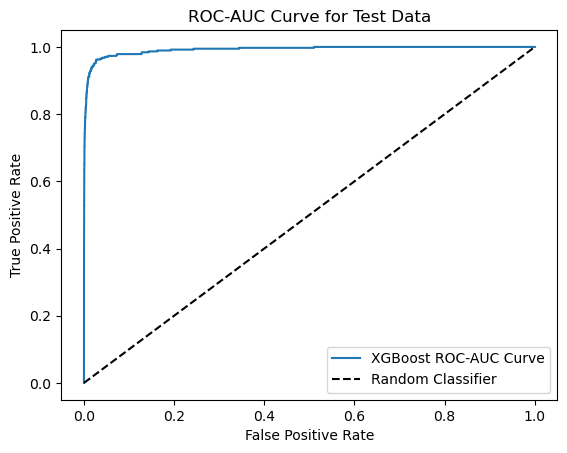

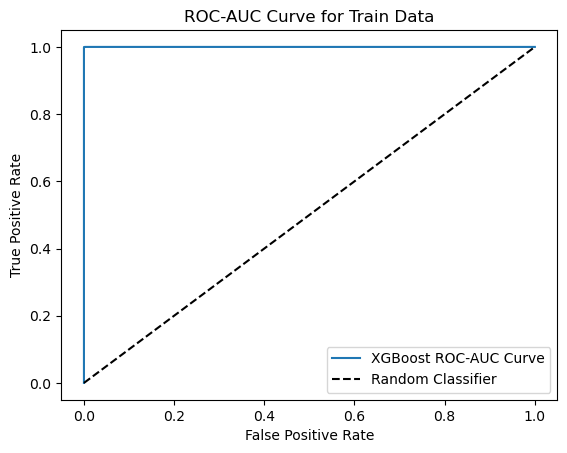

In [ ]:
# eval metrics 
train_errxgb =1- accuracy_score(y_train, y_pred_train)
test_errxgb = 1-accuracy_score(y_test, y_pred_test)
train_auc_xgb = roc_auc_score(y_train, y_proba_train)
test_auc_xgb = roc_auc_score(y_test, y_proba_test)

confxgbtrain = confusion_matrix(y_train, y_pred_train)
confxgbtest = confusion_matrix(y_test, y_pred_test)

print("Train Error:", train_errxgb, "Test Error:" , test_errxgb) 
print("The training confusion matrix is", confxgbtrain )
print("The test confusion matrix is", confxgbtest) 
print("The train AUC is", train_auc_xgb)
print("The test AUC is" , test_auc_xgb) 

#plotting ROC_AUC for test 
plt.figure()
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.plot(fpr, tpr, label = "XGBoost ROC-AUC Curve")
plt.plot([0,1],[0,1],'k--',label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Test Data")
plt.legend()

#plotting ROC_AUC for train
plt.figure()
fpr, tpr, _ = roc_curve(y_train, y_proba_train)
plt.plot(fpr, tpr, label = "XGBoost ROC-AUC Curve")
plt.plot([0,1],[0,1],'k--',label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Train Data")
plt.legend()

Comparison of Test Error and Train Error using Five Fold CV: the training errorr is nearly 0 when using XGB with the best_alpha, whereas the test error is higher at around 0.0077. 

## 10. SMOTE for Imbalance Handling

### 10.1 Correct SMOTE Usage in CV
A critical detail:  
**SMOTE must be applied inside each training fold**, not before splitting.  
Applying SMOTE before CV causes synthetic samples to leak into the validation set.

### 10.2 SMOTE + XGBoost Pipeline
We build a pipeline that:
1. Applies SMOTE to the training fold  
2. Fits an XGBoost classifier  
3. Evaluates on untouched validation data  

In [ ]:
#using pipeline to make it easier, and imblearn ensures the right CV way (no data leakage) 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

#pipeline 
pipeline_ = Pipeline([("smote", SMOTE(random_state=33)),("xgb", XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=33, n_jobs=-1))])

alphaval = [0, 0.01, 0.1, 1, 10] 
param_grid = {"xgb__reg_alpha": alphaval} 

#Cross Validation 
gridCV = GridSearchCV(estimator=pipeline_,param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1)

gridCV.fit(X_train_imputed, y_train)

#finding best alpha
best_alpha = gridCV.best_params_["xgb__reg_alpha"]
print("The best alpha value is ", best_alpha)

#applying best alpha to the XGboost smote pipeline 
xgb_smote_pipeline = Pipeline([("smote", SMOTE(random_state=33)), ("xgb", XGBClassifier(objective="binary:logistic", eval_metric="logloss",reg_alpha=best_alpha, random_state=33, n_jobs=-1))])

xgb_smote_pipeline.fit(X_train_imputed, y_train)

### 10.3 Evaluation
We compare performance against pre-SMOTE models and examine whether synthetic oversampling improves recall for the minority class.


The best alpha value is  1
Train Error: 0.014100000000000001 Test Error: 0.02100000000000002
The training confusion matrix is [[58176   824]
 [   22   978]]
The test confusion matrix is [[15354   271]
 [   65   310]]
The train AUC is 0.9977841949152543
The test AUC is 0.9822044160000001


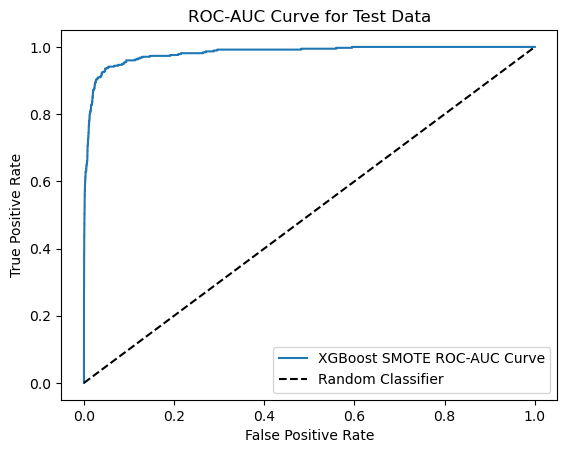

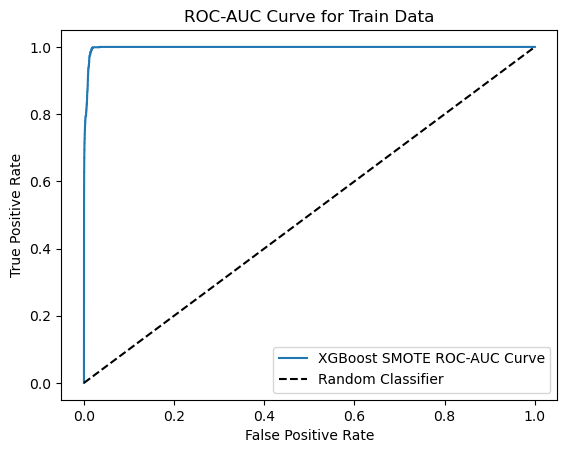

In [ ]:
#calculating errors 
y_train_pred_smote= xgb_smote_pipeline.predict(X_train)
y_test_pred_smote  = xgb_smote_pipeline.predict(X_test)

y_train_proba_smote = xgb_smote_pipeline.predict_proba(X_train)[:, 1]
y_test_proba_smote  = xgb_smote_pipeline.predict_proba(X_test)[:, 1]

train_error_smote = 1- accuracy_score(y_train, y_train_pred_smote)
test_error_smote  = 1- accuracy_score(y_test, y_test_pred_smote)
train_auc_smote = roc_auc_score(y_train, y_train_proba_smote)
test_auc_smote  = roc_auc_score(y_test,  y_test_proba_smote)

confxgbsmotetrain = confusion_matrix(y_train, y_train_pred_smote)
confxgbsmotetest = confusion_matrix(y_test, y_test_pred_smote) 

print("Train Error:", train_error_smote, "Test Error:" , test_error_smote) 
print("The training confusion matrix is", confxgbsmotetrain)
print("The test confusion matrix is", confxgbsmotetest ) 
print("The train AUC is", train_auc_smote)
print("The test AUC is" , test_auc_smote) 

#plotting ROC_AUC for test 
plt.figure()
fpr, tpr, _ = roc_curve(y_test, y_test_proba_smote)
plt.plot(fpr, tpr, label = "XGBoost SMOTE ROC-AUC Curve")
plt.plot([0,1],[0,1],'k--',label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Test Data")
plt.legend()

#plotting ROC_AUC for train
plt.figure()
fpr, tpr, _ = roc_curve(y_train, y_train_proba_smote)
plt.plot(fpr, tpr, label = "XGBoost SMOTE ROC-AUC Curve")
plt.plot([0,1],[0,1],'k--',label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Train Data")
plt.legend()

In [28]:
#COMPARING 

comparingtable = pd.DataFrame({
    "Model": ["XGBoost", "XGBoost + SMOTE"],
    "Train AUC": [train_auc_xgb, train_auc_smote],
    "Test AUC": [test_auc_xgb, test_auc_smote],
    "Train Error": [train_errxgb, train_error_smote],
    "Test Error": [test_errxgb, test_error_smote],
    "Confusion Matrix Test": [confxgbtest, confxgbsmotetest],
    "Confusion Matrix Train": [confxgbtrain, confxgbsmotetrain]
})

print("The comparison can be shown in the table below")
comparingtable

The comparison can be shown in the table below


,Model,Train AUC,Test AUC,Train Error,Test Error,Confusion Matrix Test,Confusion Matrix Train
0,XGBoost,0.999999,0.992188,0.000017,0.00775,"[[15599, 26], [98, 277]]","[[59000, 0], [1, 999]]"
1,XGBoost + SMOTE,0.997784,0.982204,0.014100,0.02100,"[[15354, 271], [65, 310]]","[[58176, 824], [22, 978]]"


The XGBoost+SMOTE has a higher train error but slightly lower test error compared to the XGBoost model alone. The confusion matrix for the test data seem to have more FN for the SMOTE but a lower number of FP compared to the test data confusion matrix for the uncompensated case (XGBoost alone). 

## 12. Conclusion

In this project, we built and evaluated several models for APS failure prediction:

- Raw Random Forest struggled due to severe class imbalance  
- Balanced Random Forest showed better minority recall  
- XGBoost provided the strongest baseline performance  
- SMOTE further improved minority detection when applied correctly inside CV  

Key insights:
- Handling imbalance is essential for rare event prediction  
- Tree-based models benefit greatly from weighting or oversampling  
- XGBoost handles high-dimensional sensor data effectively  
- Evaluation metrics must focus on AUC and recall, not accuracy  

Future extensions:
- Try ADASYN for adaptive oversampling  
- Evaluate LightGBM or CatBoost  
- Incorporate feature selection or dimensionality reduction  
- Deploy a real-time prediction pipeline  